# Assignment 2  - Neural Network

## Importing Libraries

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Importing DataSet

In [2]:
data=pd.read_csv('classification.csv')
data.head()

age   interest  success
0  23.657801  18.859917      0.0
1  22.573729  17.969223      0.0
2  32.553424  29.463651      0.0
3   6.718035  25.704665      1.0
4  14.401919  16.770856      0.0

## Splitting data in to Training and Testing Datasets

In [3]:
x = np.array(data)
np.random.shuffle(x)
train , test = x[:220,:], x[220:,:]
xtrain, y_train = train[:,0:2], train[:,2]
xtest, y_test = test[:,0:2] , test[:,2]
xtest.shape, xtrain.shape, y_train.shape,y_test.shape

((77, 2), (220, 2), (220,), (77,))

## Standardizing Data for better results and handling outliers.

In [4]:
m = np.mean(xtrain)
stded = np.std(xtrain)
x_train = (xtrain - m ) / stded
x_test = (xtest - m) / stded

# Neural Network from Scratch using ReLU

### Importing Maths and Numpy Libraries

In [5]:
# add comments to explain the code
import math
import numpy as np


## Defininig Activation Functions
### Sigmoid Function

In [6]:
#  sigmoid function
def sigmoidScalar(x): 
    return 1/(1+math.exp(-x))

# derivative of sigmoid function
def sigmoidPriScal(x): 
    return sigmoidScalar(x)*(1-sigmoidScalar(x)) 

### Relu Function

In [7]:
# ReLU function
def reluScalar(x): 
    if x > 0:
        return x
    else:
        return 0

# derivative of ReLU function
def reluPriScal(x): 
    if x > 0:
        return 1
    else:
        return 0



### Tanh Functions

In [8]:
# tanh function
def tanhScalar(x): 
    return math.tanh(x)

# derivative of tanh function
def tanhPriScal(x): 
    return 1 - math.tanh(x)**2

### Vectorizing Activation Functions

In [9]:
sigmoid = np.vectorize(sigmoidScalar) # vectorize sigmoid function
sigmoidPrime = np.vectorize(sigmoidPriScal) # vectorize derivative of sigmoid function
relu = np.vectorize(reluScalar) # vectorize ReLU function
reluPrime = np.vectorize(reluPriScal) # vectorize derivative of ReLU function
tanh = np.vectorize(tanhScalar) # vectorize tanh function
tanhPrime = np.vectorize(tanhPriScal) # vectorize derivative of tanh function

## Neural Network Implementation

In [10]:
 # class for neural network
class NeuralNetwork:
    def __init__(self, X, Y, dims, lr=1.2, iterations=3000): # constructor
        self.X = X # input
        self.Y = Y # output
        self.dims = dims # dimensions of the network
        self.lr = lr  # learning rate
        self.iterations = iterations # number of iterations
        self.length = len(self.dims)-1 # length of the network
        self.parameters = {} # parameters of the network
        self.cache = {} # cache of the network
        self.grads = {} # gradients of the network
        self.cost = 1   # cost of the network
        self.train_acc = [] # training accuracy of the network
        self.cost_list = [] # cost list of the network

    # initialize parameters of the network
    def initialize(self): 
        np.random.seed(3) # set seed for random number generation 
        for l in range(1, len(self.dims)): # for each layer
            self.parameters['W'+str(l)] = np.random.randn(self.dims[l],
                                                      self.dims[l-1])*0.01 # initialize weights
            self.parameters['b'+str(l)] = np.zeros((self.dims[l], 1)) # initialize biases
    
    # prediction of the output 
    def predict(self, X): 
        self.forward_propagation() # forward propagation
        return np.round(self.cache['A'+str(len(self.dims)-1)]) # return the output

    # forward propagation
    def forward_propagation(self): 
        self.cache['A0'] = self.X # input layer
        # For last layer, ie, the output layer 3, we need to activate using sigmoid
        # For layer 1 and 2, we need to use relu
        for l in range(1, len(self.dims)-1): # for each layer
            self.cache['Z'+str(l)] = np.dot(self.parameters['W'+str(l)],
                                            self.cache['A'+str(l-1)]) + self.parameters['b'+str(l)] # compute Z
            self.cache['A'+str(l)] = relu(self.cache['Z'+str(l)]) # compute A
        l = len(self.dims)-1    # for the last layer                    
        self.cache['Z'+str(l)] = np.dot(self.parameters['W'+str(l)],
                                        self.cache['A'+str(l-1)]) + self.parameters['b'+str(l)] # compute Z
        self.cache['A'+str(l)] = sigmoid(self.cache['Z'+str(l)]) # compute A

    # compute cost of the network
    def compute_cost(self): 
        m = self.Y.shape[0] # number of training examples
        A = self.cache['A'+str(len(self.dims)-1)] # output of the network
        self.cost = -1/m * \
            np.sum(np.multiply(self.Y, np.log(A)) +
                   np.multiply(1-self.Y, np.log(1-A))) # cost function
        self.cost = np.squeeze(self.cost) # remove the extra dimension

    # backward propagation
    def backward_propagation(self): 
        A = self.cache['A' + str(len(self.dims) - 1)] # output of the network
        m = self.X.shape[1] # number of training examples
        self.grads['dA'+str(len(self.dims)-1) 
                   ] = np.divide(A - self.Y, (1 - A) * A) # compute dA
        # Sigmoid derivative for final layer
        l = len(self.dims)-1 # for the last layer
        self.grads['dZ' + str(l)] = self.grads['dA' + str(l)] * \
            sigmoidPrime(self.cache['Z' + str(l)]) # compute dZ
        self.grads['dW' + str(l)] = 1 / m * np.dot(self.grads['dZ' +
                                                              str(l)], self.cache['A' + str(l - 1)].T) # compute dW
        self.grads['db' + str(l)] = 1 / m * \
            np.sum(self.grads['dZ' + str(l)], axis=1, keepdims=True) # compute db
        self.grads['dA' + str(l - 1)] = np.dot(self.parameters['W' +
                                                           str(l)].T, self.grads['dZ' + str(l)]) # compute dA
        # Relu derivative for previous layers
        for l in range(len(self.dims)-2, 0, -1): # for each layer
            self.grads['dZ'+str(l)] = self.grads['dA'+str(l)] * \
                reluPrime(self.cache['Z'+str(l)]) # compute dZ
            self.grads['dW'+str(l)] = 1/m*np.dot(self.grads['dZ' +
                                                            str(l)], self.cache['A'+str(l-1)].T) # compute dW
            self.grads['db'+str(l)] = 1/m * \
                np.sum(self.grads['dZ'+str(l)], axis=1, keepdims=True) # compute db
            self.grads['dA'+str(l-1)] = np.dot(self.parameters['W' +
                                                           str(l)].T, self.grads['dZ'+str(l)]) # compute dA

    # updating of the network
    def update_parameters(self): 
        for l in range(1, len(self.dims)): # for each layer
            self.parameters['W'+str(l)] = self.parameters['W'+str(l)] - \
                self.lr*self.grads['dW'+str(l)] # update W
            self.parameters['b'+str(l)] = self.parameters['b'+str(l)] - \
                self.lr*self.grads['db'+str(l)] # update b


    # Network Training
    def train(self):    
        np.random.seed(1)   # set seed for random number generation
        self.initialize()   # initialize parameters
        for i in range(self.iterations):   # for each iteration
            self.forward_propagation() # forward propagation
            self.compute_cost() # compute cost
            self.backward_propagation() # backward propagation
            self.update_parameters() # update parameters
            if i % 200 == 0: # every 200 iterations
                # Uncomment to print cost after every 200 iterations
                #print('Cost after {} iterations is {}'.format(i, self.cost))    # print cost
                # calculate prediction and accuracy for training set and append to list
                pred = self.predict(self.X) # predict the output of the network
                acc = np.sum(pred == self.Y) / self.Y.shape[0] # calculate accuracy
                self.train_acc.append(acc) # append accuracy to list
                # calculate cost for each iteration and append to list
                self.cost_list.append(self.cost) # append cost to list
        print('final  cost after', i+1, 'iterations is {}'.format(self.cost)) # print final cost

## Neural Network using ReLU with 1 hidden layer
### creating a neural network with 2 input neurons, 32 hidden layer neurons and 1 output layer neuron

In [31]:

clf1 = NeuralNetwork(x_train.T, y_train, [2, 32, 1], lr=1, iterations=5000) # create a neural network
clf1.train() # train the network

Final cost is 0.14093726439559728


### Listing costs of every 100 iterations

In [32]:
#clf1.cost_list

### PLOT - Cost vs Iterations - ReLU function - 1 Hidden Layer

In [35]:
# plot cost vs iterations
import matplotlib.pyplot as plt # import matplotlib
plt.plot(clf1.cost_list) # plot cost vs iterations
plt.title('Cost using ReLU function') # set title
plt.xlabel('Iterations * 200') # set x label
plt.ylabel('ReLU Cost') # set y label
plt.show() # show plot

### PLOT - Accuracy vs iterations - ReLU function - 1 hidden layer

In [36]:
# plot accuracy vs iterations
plt.plot(clf1.train_acc) # plot accuracy vs iterations
plt.title('Accuracy using ReLU function') # set title
plt.xlabel('Iterations * 200') # set x label
plt.ylabel('Accuracy') # set y label
plt.show() # show plot

## Neural Network using ReLU with 2 hidden layers
### Creating a neural network with 2 input neurons, 32 1st hidden layer neurons, 64 2nd layer neurons and 1 output layer neuron

In [37]:
 # creating a neural network with 2 input neurons, 32 1st hidden layer neurons, 64 2nd layer neurons and 1 output layer neuron
clf2 = NeuralNetwork(x_train.T, y_train, [2, 32, 64,1], lr=.2, iterations=5000)
clf2.train() # train the network

Final cost is 0.27715635801607197


### PLOT - Cost vs Iterations - ReLU function - 2 Hidden Layers

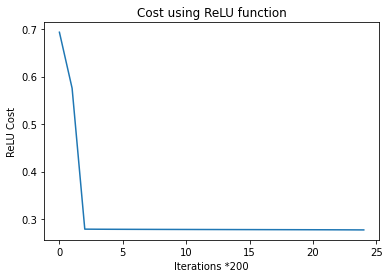

In [38]:
# plot cost vs iterations
import matplotlib.pyplot as plt # import matplotlib
plt.plot(clf2.cost_list) # plot cost vs iterations
plt.title('Cost using ReLU function') # set title
plt.xlabel('Iterations *200') # set x label
plt.ylabel('ReLU Cost') # set y label
plt.show() # show plot

### PLOT - Accuracy vs Iterations - ReLU function - 2 Hidden Layers

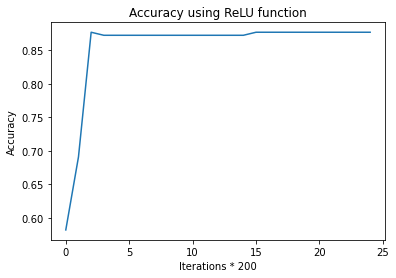

In [39]:
# plot accuracy vs iterations
plt.plot(clf2.train_acc) # plot accuracy vs iterations
plt.title('Accuracy using ReLU function') # set title
plt.xlabel('Iterations * 200') # set x label
plt.ylabel('Accuracy') # set y label
plt.show() # show plot

# Neural Network from Scratch using Tanh hypebolic

In [18]:
# neural network class
class NeuralNetwork: # neural network class
    def __init__(self, X, Y, dims, lr=1.2, iterations=3000): # initialize the network
        self.X = X # input data
        self.Y = Y  # output data
        # Including input layer and output layer. Let example be dims=4
        self.dims = dims # dimensions of the network
        self.lr = lr  # Learning rate
        self.iterations = iterations    # Number of iterations
        self.length = len(self.dims)-1 # length of the network
        self.parameters = {}    # To store parameters W and b for each layer
        self.cache = {}     # To store cache Z and A for each layer
        self.grads = {}     # To store dA, dZ, dW, db
        self.cost = 1       # Initial value does not matter
        self.train_acc = [] # To store training accuracy
        self.cost_list = [] # To store cost for each iteration

# initialize parameters
    def initialize(self):   
        np.random.seed(3)   # set seed for random number generation
        for l in range(1, len(self.dims)):  # for each layer
            self.parameters['W'+str(l)] = np.random.randn(self.dims[l],
                                                      self.dims[l-1])*0.01  # initialize W
            self.parameters['b'+str(l)] = np.zeros((self.dims[l], 1))   # initialize b

# predicting the output 
    def predict(self, X):   
        self.forward_propagation()  # forward propagation
        return np.round(self.cache['A'+str(len(self.dims)-1)])  # return prediction

# forward propagation
    def forward_propagation(self):  
        self.cache['A0'] = self.X   # set A0 to input data
        for l in range(1, len(self.dims)-1):    # for each layer
            self.cache['Z'+str(l)] = np.dot(self.parameters['W'+str(l)],
                                            self.cache['A'+str(l-1)]) + self.parameters['b'+str(l)] # compute Z
            self.cache['A'+str(l)] = tanh(self.cache['Z'+str(l)])   # compute A
        l = len(self.dims)-1    # for last layer
        self.cache['Z'+str(l)] = np.dot(self.parameters['W'+str(l)],
                                        self.cache['A'+str(l-1)]) + self.parameters['b'+str(l)]     # compute Z
        self.cache['A'+str(l)] = sigmoid(self.cache['Z'+str(l)])    # compute A

# computing cost
    def compute_cost(self):  
        m = self.Y.shape[0] # number of training examples
        A = self.cache['A'+str(len(self.dims)-1)]   # output of the network
        self.cost = -1/m * \
            np.sum(np.multiply(self.Y, np.log(A)) +
                   np.multiply(1-self.Y, np.log(1-A)))  # compute cost
        self.cost = np.squeeze(self.cost)   # remove dimensions of size 1

# backward propagation
    def backward_propagation(self): 
        A = self.cache['A' + str(len(self.dims) - 1)]   # output of the network
        m = self.X.shape[1]     # number of training examples
        self.grads['dA'+str(len(self.dims)-1)
                   ] = np.divide(A - self.Y, (1 - A) * A)   # compute dA
        # Sigmoid derivative for final layer
        l = len(self.dims)-1    # for last layer
        self.grads['dZ' + str(l)] = self.grads['dA' + str(l)] * \
            sigmoidPrime(self.cache['Z' + str(l)])  # compute dZ
        self.grads['dW' + str(l)] = 1 / m * np.dot(self.grads['dZ' +
                                                              str(l)], self.cache['A' + str(l - 1)].T)  # compute dW
        self.grads['db' + str(l)] = 1 / m * \
            np.sum(self.grads['dZ' + str(l)], axis=1, keepdims=True)        # compute db
        self.grads['dA' + str(l - 1)] = np.dot(self.parameters['W' +
                                                           str(l)].T, self.grads['dZ' + str(l)])    # compute dA
        # tanh derivative for previous layers
        for l in range(len(self.dims)-2, 0, -1):    # for each layer
            self.grads['dZ'+str(l)] = self.grads['dA'+str(l)] * \
                tanhPrime(self.cache['Z'+str(l)])   # compute dZ
            self.grads['dW'+str(l)] = 1/m*np.dot(self.grads['dZ' +
                                                            str(l)], self.cache['A'+str(l-1)].T)    # compute dW
            self.grads['db'+str(l)] = 1/m * \
                np.sum(self.grads['dZ'+str(l)], axis=1, keepdims=True)  # compute db
            self.grads['dA'+str(l-1)] = np.dot(self.parameters['W' +
                                                           str(l)].T, self.grads['dZ'+str(l)])  # compute dA

# updating parameters
    def update_parameters(self):    
        for l in range(1, len(self.dims)):  # for each layer
            self.parameters['W'+str(l)] = self.parameters['W'+str(l)] - \
                self.lr*self.grads['dW'+str(l)]  # update W
            self.parameters['b'+str(l)] = self.parameters['b'+str(l)] - \
                self.lr*self.grads['db'+str(l)] # update b

# Network training
    def train(self):    
        np.random.seed(1)   # set seed for random number generation
        self.initialize()   # initialize parameters
        for i in range(self.iterations):    # for each iteration
            self.forward_propagation()  # forward propagation
            self.compute_cost() # compute cost
            self.backward_propagation() # backward propagation
            self.update_parameters()    # update parameters
            if i % 200 == 0:    # print cost every 200 iterations
                # Uncomment to print costs after every 200 iterations
                #print('Cost after {} iterations is {}'.format(i, self.cost))
                # calculate prediction and accuracy for training set and append to list
                pred = self.predict(self.X)
                acc = np.sum(pred == self.Y) / self.Y.shape[0]
                self.train_acc.append(acc)
                # calculate cost for each iteration and append to list
                self.cost_list.append(self.cost)
        print('Final cost is {}'.format(self.cost))

## Neural Network with Tanh using 4 hidden layers
### Creating a neural network with 2 input neurons, 128 1st hidden layer neurons, 64 2nd and 3rd hidden layer neurons, 32 4th hidden layer neurons and 1 output layer neuron

In [19]:

clf3 = NeuralNetwork(x_train.T, y_train, [2, 128 , 64 , 64 ,32,1], lr=1.1, iterations=5000)    # create classifier
clf3.train()   # train the classifier

Final cost is 0.10509503611960602


### PLOT - Cost vs Iterations - Tanh function - 4 Hidden Layers

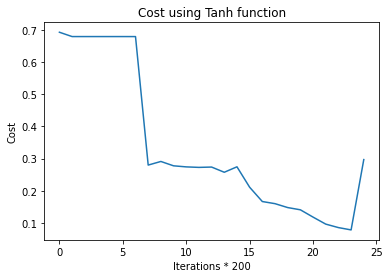

In [20]:
# plot cost vs iterations

plt.plot(clf3.cost_list) # plot cost vs iterations
plt.title('Cost using Tanh function')   # plot title
plt.xlabel('Iterations * 200')    # x-axis label
plt.ylabel('Cost')  # y-axis label
plt.show()  # show plot

### PLOT - Accuracy vs Iterations - Tanh function - 4 Hidden Layers

In [21]:
# plot accuracy vs iterations
plt.plot(clf3.train_acc)     # plot accuracy vs iterations
plt.title('Accuracy using Tanh function')       # plot title

plt.xlabel('Iterations')    # x-axis label
plt.ylabel('Accuracy')  # y-axis label
plt.show()  # show plot

## Neural Network with Tanh using 2 hidden layers
### Creating a neural network with 2 input neurons, 64 1st hidden layer neurons, 32 2nd hidden layer neurons and 1 output layer neuron

In [22]:

clf4 = NeuralNetwork(x_train.T, y_train, [2, 64 ,32 ,1], lr=1.1, iterations=5000)  # create classifier
clf4.train() # train the classifier

Final cost is 0.06192217536001346


### PLOT - Cost vs Iterations - Tanh function - 2 Hidden Layers

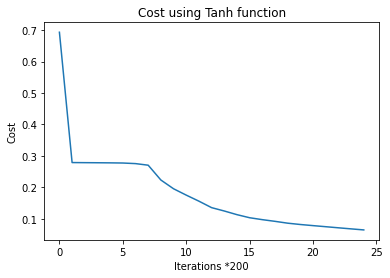

In [23]:
# plot cost vs iterations   
import matplotlib.pyplot as plt # import matplotlib
plt.plot(clf4.cost_list) # plot cost vs iterations
plt.title('Cost using Tanh function')   # plot title
plt.xlabel('Iterations *200')    # x-axis label
plt.ylabel('Cost')  # y-axis label
plt.show()  # show plot

### PLOT - Accuracy vs Iterations - Tanh function - 2 Hidden Layers

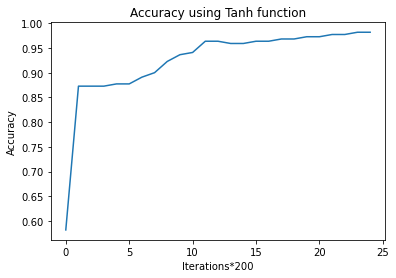

In [24]:
# plot accuracy vs iterations
plt.plot(clf4.train_acc)    # plot accuracy vs iterations
plt.title('Accuracy using Tanh function')    # plot title
plt.xlabel('Iterations*200')    # x-axis label
plt.ylabel('Accuracy')  # y-axis label
plt.show()  # show plot

## Neural Network with Tanh using 1 hidden layers
### Creating a neural network with 2 input neurons, 32  hidden layer neurons 1 output layer neuron

In [25]:
import numpy as np  # import numpy  
clf5 = NeuralNetwork(x_train.T, y_train, [2, 32 ,1], lr=1, iterations=5000)  # create classifier
clf5.train() # train the classifier

Final cost is 0.14093726439559728


### PLOT - Cost vs Iterations - Tanh function - 1 Hidden Layers

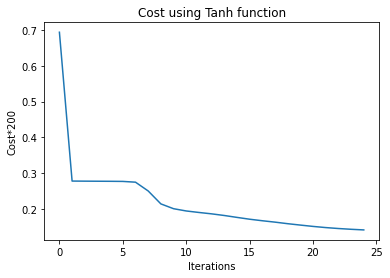

In [26]:
# plot cost vs iterations
import matplotlib.pyplot as plt # import matplotlib 
plt.plot(clf5.cost_list) # plot cost vs iterations
plt.title('Cost using Tanh function')   # plot title
plt.xlabel('Iterations')    # x-axis label
plt.ylabel('Cost*200')  # y-axis label
plt.show()  # show plot

### PLOT - Accuracy vs Iterations - Tanh function - 1 Hidden Layers

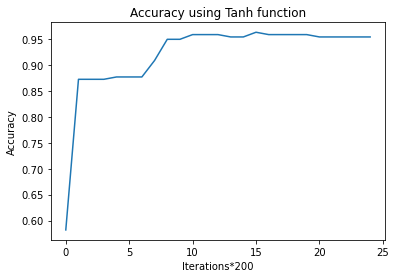

In [27]:
# plot accuracy vs iterations
plt.plot(clf5.train_acc)   # plot accuracy vs iterations
plt.title('Accuracy using Tanh function')   # plot title
plt.xlabel('Iterations*200')    # x-axis label
plt.ylabel('Accuracy')      # y-axis label
plt.show()  # show plot

### PLOT - Cost vs Iterations - for all configurations of Network

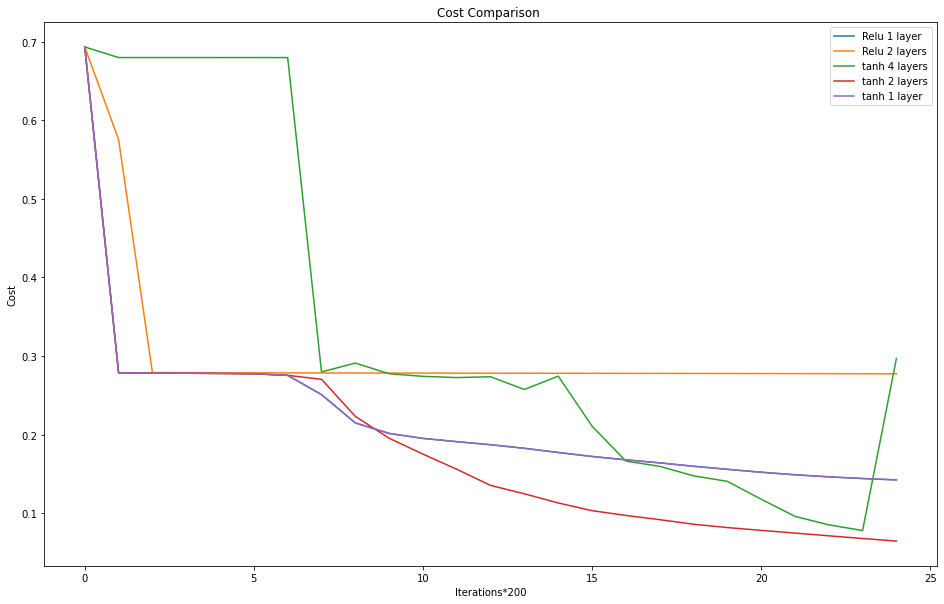

In [42]:
# plot lines
plt.figure(figsize=(16, 10))
plt.plot(clf1.cost_list, label = "Relu 1 layer")
plt.plot(clf2.cost_list, label = "Relu 2 layers")
plt.plot(clf3.cost_list, label = "tanh 4 layers")
plt.plot(clf4.cost_list, label = "tanh 2 layers")
plt.plot(clf5.cost_list, label = "tanh 1 layer")
plt.title('Cost Comparison ')   # plot title
plt.xlabel('Iterations*200')    # x-axis label
plt.ylabel('Cost')      # y-axis label
plt.legend()
plt.show()

### PLOT - Accuracy vs Iterations - for all configurations of Network

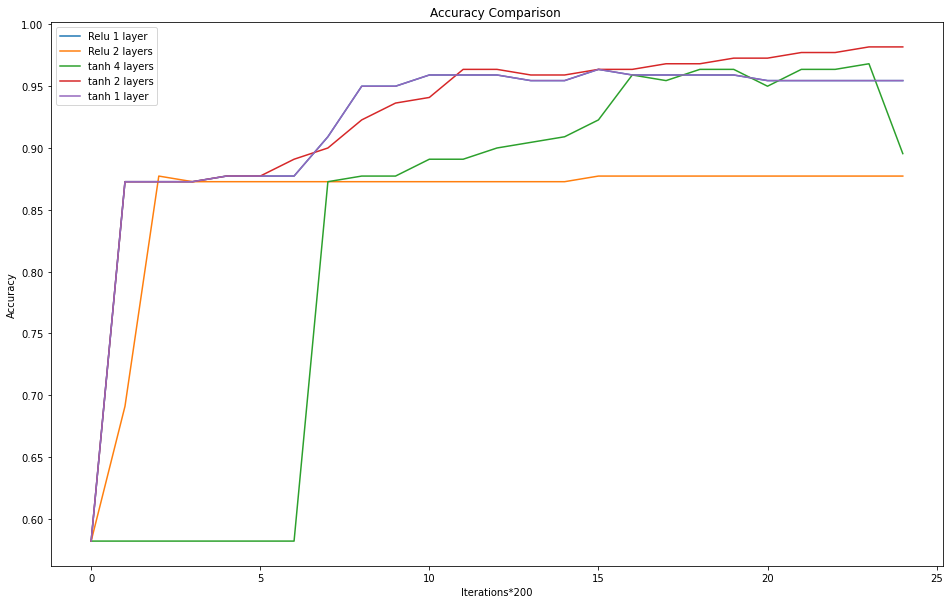

In [43]:
# plot lines
plt.figure(figsize=(16, 10))
plt.plot(clf1.train_acc, label = "Relu 1 layer")
plt.plot(clf2.train_acc, label = "Relu 2 layers")
plt.plot(clf3.train_acc, label = "tanh 4 layers")
plt.plot(clf4.train_acc, label = "tanh 2 layers")
plt.plot(clf5.train_acc, label = "tanh 1 layer")
plt.title('Accuracy Comparison ')   # plot title
plt.xlabel('Iterations*200')    # x-axis label
plt.ylabel('Accuracy')      # y-axis label
plt.legend()
plt.show()